# The Fast Bilateral Solver
Jonathan T. Barron & Ben Poole

_Guillaume Dalle, MVA 2018-2019_
***

## 1. Algorithms

Necessary imports

In [1]:
# Math libraries
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as spalg
import scipy.stats as stats
import itertools

# Plotting libraries
import matplotlib.pyplot as plt

# Image libraries
import matplotlib.image as mpimg
from PIL import Image
import scipy.ndimage as ndimage
import skimage.transform

# Progress bar
from tqdm import tqdm, trange

### 1.1 Fast Bilateral Solver

Switch between two representations of a bilateral grid vertex.

In [2]:
def get_coord_from_vertex(v, grid_shape):
    """Get the coordinates of a grid vertex from its index."""
    v = np.array(v)
    grid_shape = np.array(grid_shape)
    prod = np.cumprod(grid_shape[::-1])[::-1][1:][:, None]
    first_coord = (v // prod) % grid_shape[:-1][:, None]
    last_coord = v % grid_shape[-1]
    return np.vstack([first_coord, last_coord]).T

def get_vertex_from_coord(coord, grid_shape):
    """Get the index of a grid vertex from its coordinates."""
    coord = np.array(coord)
    grid_shape = np.array(grid_shape)
    prod = np.cumprod(grid_shape[::-1])[::-1][1:][:, None]
    return (coord[:, :-1].dot(prod) + coord[:, -1:])[:, 0]

Implementation of the bilateral grid with the splat-blur-slice decomposition

In [3]:
class BilateralGrid:
    
    def __init__(self, ref_img, sigma):
        """Initialize a bilateral grid with a reference image and a standard deviation vector."""
        self.ref_img = ref_img
        self.sigma = sigma
        
        self.compute_everything()
        
    def compute_everything(self):
        """Perform all computations necessary for the fast bilateral solver."""
        self.compute_useful_stuff()
        self.compute_splat()
        self.compute_blur()
        self.compute_bistochastization()
        self.compute_pyramid_space()
        
    def compute_useful_stuff(self):
        """Translate the pixels of a 2d image into D-dimensional positions."""    
        # Spatial coordinates of all the image pixels
        self.x_ref_img = np.indices(self.ref_img.shape[:2])[0].flatten()
        self.y_ref_img = np.indices(self.ref_img.shape[:2])[1].flatten()
        
        # Positions (coordinates + values) of all the image pixels
        self.pos_ref_img = np.hstack([
            self.x_ref_img[:, None],
            self.y_ref_img[:, None],
            self.ref_img[self.x_ref_img, self.y_ref_img]
        ])
        
        # Dimension of the position: 2 + number of channels
        self.D = 2 + self.ref_img.shape[2]
        
        # Shape of the D-dimensional bilateral grid:
        # - sizes of the coordinate axes
        # - sizes of the value axes
        self.grid_shape = np.hstack([
            np.ceil(self.ref_img.shape[:2] / self.sigma[:2]) + 1,
            np.ceil(self.ref_img.max() / self.sigma[2:]) + 1
        ]).astype(int)
        
        # Number of pixels and vertices
        self.n_pixels = np.prod(self.ref_img.shape[:2])
        self.n_vertices = np.prod(self.grid_shape)
        
    def compute_splat(self):
        """Compute the splat matrix: links pixels to the associated vertices in the grid."""
        tqdm(desc="Splat matrix computation")
        
        # Positions of the nearest neighbor vertices associated with each image pixel
        self.pos_grid = np.rint(self.pos_ref_img / self.sigma).astype(int)
        # Indices of the nearest neighbor vertices
        self.nearest_neighbors = get_vertex_from_coord(self.pos_grid, self.grid_shape)
        
        # Vertices that are nearest neighbor to at least one pixel
        # (all the other vertices of the grid are useless)
        self.useful_vertices = np.sort(np.unique(self.nearest_neighbors))
        self.n_useful_vertices = len(self.useful_vertices)
        
        # Dictionary of coordinates for useful vertices
        self.useful_vertex_to_coord = get_coord_from_vertex(self.useful_vertices, self.grid_shape)
        # Dictionary of indices for useful vertices
        self.useful_vertex_to_ind = np.empty(self.n_vertices)
        self.useful_vertex_to_ind[self.useful_vertices] = np.arange(self.n_useful_vertices)
        
        # Record if a given vertex is useful (comes in handy for slicing)
        self.vertex_is_useful = np.zeros(self.n_vertices)
        self.vertex_is_useful[self.useful_vertices] = 1
        
        # Construction of the splat matrix: (vertex, pixel) => neighbor?
        row_ind = self.useful_vertex_to_ind[self.nearest_neighbors]
        col_ind = np.arange(self.n_pixels)
        data = np.ones_like(row_ind)
        self.S = sparse.csr_matrix(
            (data, (row_ind, col_ind)), shape=(self.n_useful_vertices, self.n_pixels)
        )
        
    def compute_blur(self):
        """Compute the blur matrix: superposition of (1, 2, 1) filters on the bilateral grid."""
        B = sparse.lil_matrix((self.n_useful_vertices, self.n_useful_vertices))
        # Fill the diagonal of the blur matrix
        B[np.arange(self.n_useful_vertices), np.arange(self.n_useful_vertices)] = 2 * self.D

        # List all the +-1 coordinate changes possible in D dimensions
        possible_neighbor_steps = [
            np.array([0] * dim + [1] + [0] * (self.D - dim - 1))
            for dim in range(self.D)
        ] + [
            np.array([0] * dim + [-1] + [0] * (self.D - dim - 1))
            for dim in range(self.D)
        ]

        for neighbor_step in tqdm(possible_neighbor_steps, desc="Blur matrix computation"):
            # Compute the +-1 neighbors only for the useful vertices
            neighbors_coord = self.useful_vertex_to_coord + neighbor_step
            
            # Check whether these neighbors are still in the grid
            neighbors_exist = True
            for dim, dim_size in enumerate(self.grid_shape):
                neighbors_exist = (
                    neighbors_exist &
                    (neighbors_coord[:, dim] >= 0) &
                    (neighbors_coord[:, dim] < dim_size)
                )
            
            # Select only the vertices whose neighbors are still in the grid
            vertices_with_existing_neighbors = self.useful_vertices[neighbors_exist]
            existing_neighbors_coord = neighbors_coord[neighbors_exist]
            existing_neighbors_vertices = get_vertex_from_coord(existing_neighbors_coord, self.grid_shape)
            
            # Select only the vertices whose neighbors are also useful
            neighbors_among_useful = self.vertex_is_useful[existing_neighbors_vertices].astype(bool)
            vertices_with_useful_neighbors = vertices_with_existing_neighbors[neighbors_among_useful]
            useful_neighbors_vertices = existing_neighbors_vertices[neighbors_among_useful]
            
            # Construct splat matrix: (vertex, vertex) => filter coefficient
            row_ind = self.useful_vertex_to_ind[vertices_with_useful_neighbors]
            col_ind = self.useful_vertex_to_ind[useful_neighbors_vertices]
            B[row_ind, col_ind] = 1

        self.B = B.tocsr()
        
    def compute_bistochastization(self, iterations=20):
        """Compute diagonal bistochastization matrices."""
        tqdm(desc="Bistochastization")
        m = self.S.dot(np.ones(self.S.shape[1]))
        n = np.ones(self.B.shape[1])
        for it in range(iterations):
            new_n = np.sqrt((n * m) / (self.B.dot(n)))
            if np.linalg.norm(new_n - n) < 1e-5:
                break
            else:
                n = new_n
        Dn = sparse.diags(n)
        Dm = sparse.diags(m)
        
        self.Dn, self.Dm = Dn, Dm
        
    def compute_pyramid_space(self):
        """Compute pyramidal decomposition."""
        self.S_pyr = build_pyramid(self.useful_vertex_to_coord)
        self.P = build_P(self.S_pyr)
        self.z_weight_init = build_z_weight(self.S_pyr, alpha=4, beta=0)
        self.z_weight_precond = build_z_weight(self.S_pyr, alpha=2, beta=5)

Preconditioned conjugate gradient algorithm for least-squares optimization

In [4]:
def prec_conj_grad(A, b, init, M_1, channel=0, iterations=25):
    """Perform preconditioned conjugate gradient descent."""
    x = init
    r = b - A.dot(x)
    d = M_1(r)
    delta_new = r.dot(d)
    for it in trange(iterations, desc="Conjugate gradient - channel {}".format(channel)):
        q = A.dot(d)
        alpha = delta_new / d.dot(q)
        x = x + alpha * d
        r = r - alpha * q
        s = M_1(r)
        delta_old = delta_new
        delta_new = r.dot(s)
        beta = delta_new / delta_old
        d = s + beta * d
    return x

Simple initialization and preconditioning

In [5]:
def M_jacobi(y, A):
    print("jac")
    return y / A.diagonal()

Pyramid space construction

In [6]:
def bilateral_representation(V, sigma):
    """Compute a bilateral splat matrix for a matrix V of abstract pixels positions."""
    D = V.shape[1]
    grid_shape = np.ceil((V.max(axis=0) / sigma) + 1).astype(int)
    
    n_abstract_pixels = len(V)
    n_vertices = np.prod(grid_shape)
    
    pos_grid = np.rint(V / sigma).astype(int)

    # Positions of the nearest neighbor vertices associated with each abstract pixel
    nearest_neighbors = get_vertex_from_coord(pos_grid, grid_shape)
    # Vertices that are nearest neighbor to at least one pixel
    # (all the other vertices of the grid are useless)
    useful_vertices = np.sort(np.unique(nearest_neighbors))
    n_useful_vertices = len(useful_vertices)
    
    # Dictionary of indices for useful vertices
    useful_vertex_to_ind = np.empty(n_vertices)
    useful_vertex_to_ind[useful_vertices] = np.arange(n_useful_vertices)
    
    # Construction of the splat matrix: (vertex, abstract pixel) => neighbor?
    row_ind = useful_vertex_to_ind[nearest_neighbors]
    col_ind = np.arange(n_abstract_pixels)
    data = np.ones_like(row_ind)
    S = sparse.csr_matrix(
        (data, (row_ind, col_ind)), shape=(n_useful_vertices, n_abstract_pixels)
    )
        
    # Positions of the useful vertices from the grid
    new_V = get_coord_from_vertex(useful_vertices, grid_shape)
        
    return S, new_V

In [7]:
def build_pyramid(useful_vertex_to_coord):
    """Construct a pyramid of ever coarser splat matrices."""
    tqdm(desc="Pyramid space construction")
    V = useful_vertex_to_coord
    S_pyr = []
    while len(V) > 1:
        Sk, V = bilateral_representation(V, 2 * np.ones(V.shape[1]))
        S_pyr.append(Sk)
    return S_pyr

def build_P(S_pyr):
    """Deduce the hierarchical projection matrix from the pyramid of splat matrices."""
    prod = sparse.eye(S_pyr[0].shape[1])
    P = prod
    for s in S_pyr:
        prod = s.dot(prod)
        P = sparse.vstack([P, prod])
    return P

def build_z_weight(S_pyr, alpha, beta):
    """Compute weights for all the stages of the pyramid space."""
    z_weight = np.ones(S_pyr[0].shape[1])
    for k, s in enumerate(S_pyr):
        z_weight = np.hstack([
            z_weight,
            (alpha ** (- beta - k - 1)) * np.ones(s.shape[0])
        ])
    return z_weight

Hierarchical initialization and preconditioning

In [8]:
def M_hier(y, A, P, z_weight):
    """Compute hierarchical preconditioner."""
    z_size, y_size = P.shape
    
    P1 = P.dot(np.ones(y_size))
    Py = P.dot(y)
    PA = P.dot(A.diagonal())
    
    return P.T.dot(z_weight * P1 * Py / PA)

def y_hier(S, C, T, P, z_weight):
    """Compute hierarchical initialization."""
    z_size, y_size = P.shape
    
    P1 = P.dot(np.ones(y_size))
    PSc = P.dot(S.dot(C))
    PSct = P.dot(S.dot(C * T))

    y_init = (
        P.T.dot(z_weight * PSct / P1) /
        P.T.dot(z_weight * PSc / P1)
    )
    
    return y_init

Least squares solution from bilateral grid

In [9]:
def solve(bilateral_grid, C, T, lambd, precond_init_method="hierarchical", channel=0):
    """Solve a least squares problem 
    from its bistochastized splat-blur-slice decomposition
    using the preconditioned conjugate gradient."""
    # Retrieve information from the bilateral grid object
    S, B = bilateral_grid.S, bilateral_grid.B
    Dn, Dm = bilateral_grid.Dn, bilateral_grid.Dm
    
    # Compute the coefficients of the least-squares problem min Ax^2 + bx + c
    A = lambd * (Dm - Dn.dot(B).dot(Dn)) + sparse.diags(S.dot(C))
    b = S.dot(C * T)
    c = 0.5 * (C * T).dot(T)
    
    # Apply chosen preconditioning and initialization
    if precond_init_method == "simple":
        # Define initial vector and preconditioning function
        y_init = S.dot(C * T) / np.clip(S.dot(C), a_min=1, a_max=None)
        def M_1(y):
            return M_jacobi(y, A)
    
    elif precond_init_method == "hierarchical":
        # Retrieve pyramid information from the bilateral grid object
        P = bilateral_grid.P
        z_weight_init = bilateral_grid.z_weight_init
        z_weight_precond = bilateral_grid.z_weight_precond
        # Define initial vector and preconditioning function
        y_init = y_hier(S, C, T, P, z_weight_init)
        def M_1(y):
            return M_hier(y, A, P, z_weight_precond)
        
    else:
        raise ValueError("Wrong preconditioning")

    # Compute the optimal solution
    y_opt = prec_conj_grad(A, b, init=y_init, M_1=M_1, channel=channel)
    return y_opt

### 1.2 Domain transform

Various implementations of the box filter

In [10]:
# In each function, ct is the 1d domain transform used to measure the distance between the pixel positions

def box_filter_naive(I, ct, sigma_H):
    """Apply a box filter with a naive for loop."""
    r = sigma_H * np.sqrt(3)
    J = np.empty_like(I)
    
    dim = I.shape[0]
    for p in range(dim):
        J_p = 0
        K_p = 0
        for q in range(p, dim):
            if abs(ct[q] - ct[p]) > r:
                break
            J_p += I[q, :]
            K_p += 1
        for q in range(p-1, -1):
            if abs(ct[q] - ct[p]) > r:
                break
            J_p += I[q, :]
            K_p += 1 
        J[p, :] = J_p[:] / K_p
    return J

def box_filter_recursive1(I, ct, sigma_H):
    """Apply a recursive box filter."""
    a = np.exp(-np.sqrt(2) / sigma_H)
    dim, channels = I.shape
    
    J_tmp = np.empty_like(I)
    J_tmp[0, :] = I[0, :]
    for p in range(1, dim):
        d = ct[p] - ct[p-1]
        J_tmp[p, :] = (1 - a**d) * I[p, :] + (a**d) * J_tmp[p-1, :]
    
    J = np.empty_like(I)
    J[-1, :] = J_tmp[-1, :]
    for p in range(dim-2, -1, -1):
        d = ct[p+1] - ct[p]
        J[p, :] = (1 - a**d) * J_tmp[p, :] + (a**d) * J[p+1, :]
    
    return J

def box_filter_recursive_sparse(I, ct, sigma_H):
    """Apply a recursive box filter with sparse matrices for faster computation."""
    a = np.exp(-np.sqrt(2) / sigma_H) 
    d = np.diff(ct)
    J = np.empty_like(I)
    
    dim, channels = I.shape
    
    A_forward = sparse.diags([1] + list(1 - a**d))
    B_forward = sparse.identity(dim) - sparse.diags(a**d, -1)
    
    A_backward = sparse.diags(list(1 - a**d) + [1])
    B_backward = sparse.identity(dim) - sparse.diags(a**d, 1)
    
    for channel in range(channels):
        J[:, channel] = spalg.spsolve(B_forward, A_forward.dot(I[:, channel]))
        J[:, channel] = spalg.spsolve(B_backward, A_backward.dot(J[:, channel]))
    
    return J

One-dimensional smoothing of columns and rows with a box filter, combined into the domain transform

In [11]:
def smooth_cols(I, sigma_s, sigma_r, it, I_ref=None, N_it=3):
    """Apply a bilateral filter on all columns of an image."""
    if I_ref is None:
        I_ref = I
    # Compute the current spatial std of the filter
    sigma_H = sigma_s * np.sqrt(3) * (2 ** (N_it - it)) / np.sqrt(4 ** N_it - 1)
    # Intialize the new image
    new_I = np.empty_like(I)
    # Compute the vertical spatial derivative of the image channels
    I_ref_prime = np.vstack([I_ref[:1, :, :], np.diff(I_ref, axis=0)])
    for col in trange(I.shape[1], desc="Domain transform - iteration {} - columns".format(it)):
        # Compute the domain transform
        ct = np.cumsum(1 + (sigma_s / sigma_r) * np.abs(I_ref_prime[:, col, :].sum(axis=1)))
        # Apply the bilateral box filter
        new_I_slice = box_filter_recursive_sparse(I[:, col, :], ct, sigma_H)
        # Fill the column of the new image
        new_I[:, col, :] = new_I_slice
    return new_I

def smooth_rows(I, sigma_s, sigma_r, it, I_ref=None, N_it=3):
    """Apply a bilateral filter on all rows of an image."""
    if I_ref is None:
        I_ref = I
    sigma_H = sigma_s * np.sqrt(3) * (2 ** (N_it - it)) / np.sqrt(4 ** N_it - 1)
    # Intialize the new image
    new_I = np.empty_like(I)
    # Compute the horizontal spatial derivative of the image channels
    I_ref_prime = np.hstack([I_ref[:, :1, :], np.diff(I_ref, axis=1)])
    for row in trange(I.shape[0], desc="Domain transform - iteration {} - rows".format(it)):
        # Compute the domain transform
        ct = np.cumsum(1 + (sigma_s / sigma_r) * np.abs(I_ref_prime[row, :, :].sum(axis=1)))
        # Apply the bilateral box filter
        new_I_slice = box_filter_recursive_sparse(I[row, :, :], ct, sigma_H)
        # Fill the row of the new image
        new_I[row, :, :] = new_I_slice
    return new_I

def domain_transform(I0, sigma_s, sigma_r, I_ref=None, N_it=3):
    """Apply the domain transform to I0 with spatial std sigma_s and value std sigma_r."""
    I = I0.copy()
    for it in range(1, N_it+1):
        for axis in [0, 1]:
            if axis == 1:
                I = smooth_rows(I, sigma_s, sigma_r, it, I_ref=I_ref, N_it=N_it)
            else:
                I = smooth_cols(I, sigma_s, sigma_r, it, I_ref=I_ref, N_it=N_it)
    return I

### 1.3 Specific tasks and visualization

Specific task 1: edge-aware smoothing

In [12]:
def smoothing(
    ref_img,
    # Bilateral solver parameters
    lambd, sigma_xy, sigma_l=None, sigma_rgb=None,
    # Domain transform parameters
    sigma_s=None, sigma_r=None, dt_it=None,
    # Visualization parameters
    show=True, file_name=None,
    # Add sharpening result
    sharp=False
):
    # Choose the right set of standard deviations
    if ref_img.shape[2] == 1:
        sigma = np.array([sigma_xy, sigma_xy, sigma_l])
    elif ref_img.shape[2] == 3:
        sigma = np.array([sigma_xy, sigma_xy, sigma_rgb, sigma_rgb, sigma_rgb])
    
    # Create the bilateral grid
    bilateral_grid = BilateralGrid(ref_img, sigma)
    S, B = bilateral_grid.S, bilateral_grid.B
    
    # The target image is the same as the reference image
    target_img = ref_img
    new_img = np.empty_like(target_img)
    
    # Perform smoothing channel by channel
    for channel in range(target_img.shape[2]):
        T = target_img[:, :, channel].flatten()
        # The confidence in each pixel of the target is the same
        C = np.ones_like(T)

        # Compute bilateral space solution
        y = solve(bilateral_grid, C, T, lambd, channel=channel)
        # Go back to pixel space
        x = S.T.dot(y).reshape(ref_img.shape[:2])
        
        # Fill the corresponding channel of the new image
        new_img[:, :, channel] = x
        
    # Apply domain transform if needed
    if sigma_s is not None and sigma_r is not None:
        new_img = domain_transform(
            I0=new_img, I_ref=new_img,
            sigma_s=sigma_s, sigma_r=sigma_r, N_it=dt_it,
        )
       
    # Visualize and/or save
    if show:
        show_smoothing(ref_img, new_img, sharp=sharp)
    if file_name is not None:
        save_smoothing(ref_img, new_img, file_name, sharp=sharp)
    
    return new_img

Specific task 2: colorization

In [13]:
def colorization(
    ref_img, target_img,
    lambd, sigma_xy, sigma_l,
    sigma_s=None, sigma_r=None, dt_it=None,
    show=True, file_name=None
):
    sigma = np.array([sigma_xy, sigma_xy, sigma_l])
    
    # Create the bilateral grid
    bilateral_grid = BilateralGrid(ref_img, sigma)
    S, B = bilateral_grid.S, bilateral_grid.B
    
    # The new image will have LUV channels
    new_img = np.empty_like(target_img)
    # The luminance channel is the same as in the reference black and white image
    new_img[:, :, 0] = ref_img[:, :, 0]

    for channel in range(1, 3):
        
        T = target_img[:, :, channel].flatten()
        # The confidence in the target pixels is zero...
        C = np.zeros_like(T)
        # ... except for those that have a color mark
        C[T != np.median(T)] = 1
        
        # Compute bilateral space solution
        y = solve(bilateral_grid, C, T, lambd, channel=channel)
        # Go back to pixel space
        x = S.T.dot(y).reshape(ref_img.shape[:2])
        
        # Fill the corresponding channel of the new image
        new_img[:, :, channel] = x
        
    # Apply domain transform if needed
    if sigma_s is not None and sigma_r is not None:
        new_img = domain_transform(
            I0=new_img, I_ref=ref_img,
            sigma_s=sigma_s, sigma_r=sigma_r, N_it=dt_it,
        )
        
    # Visualize and/or save
    if show:
        show_colorization(ref_img, target_img, new_img)
    if file_name is not None:
        save_colorization(ref_img, target_img, new_img, file_name)
    
    return new_img

Specific task 3: depth superresolution

In [14]:
def depth_superresolution(
    ref_img, target_img, f,
    lambd, sigma_xy, sigma_l, sigma_uv,
    sigma_s=None, sigma_r=None, dt_it=None,
    show=True, file_name=None
):
    sigma = np.array([sigma_xy, sigma_xy, sigma_l, sigma_uv, sigma_uv])
    # Create the bilateral grid
    bilateral_grid = BilateralGrid(ref_img, sigma)
    S, B = bilateral_grid.S, bilateral_grid.B

    # The confidence in each target pixel is a gaussian bump dictated by the upsampling factor
    T = target_img.flatten()
    C_block = stats.norm.pdf(
        x=np.indices((f, f))[0] + np.indices((f, f))[1],
        loc=0, scale=f/4
    )
    C = np.tile(C_block, (target_img.shape[0] // f, target_img.shape[1] // f)).flatten()

    # Compute bilateral space solution
    y = solve(bilateral_grid, C, T, lambd, channel=0)
    # Go back to pixel space
    x = S.T.dot(y).reshape(ref_img.shape[:2])

    # Fill luminance channel of the new image
    new_img = x[:, :, None]
    
    # Apply domain transform if needed
    if sigma_s is not None and sigma_r is not None:
        new_img = domain_transform(
            I0=new_img, I_ref=ref_img,
            sigma_s=sigma_s, sigma_r=sigma_r, N_it=dt_it
        )
    
    # Visualize and/or save
    if show:
        show_depth_superresolution(ref_img, target_img, new_img)
    if file_name is not None:
        save_depth_superresolution(ref_img, target_img, new_img, file_name)
        
    return new_img

Plotting images and saving files

In [15]:
def normalize(img):
    m = img.min()
    M = img.max()
    return (255 * (img - m) / (M - m)).astype(int)

In [16]:
def show_smoothing(ref_img, new_img, sharp=False):
    new_img = np.clip(new_img, a_min=0, a_max=255)
    if ref_img.shape[2] == 1:
        ref_img, new_img = ref_img[:, :, 0], new_img[:, :, 0]
        cmap= "Greys_r"
    else:
        cmap = None
    if not sharp:
        fig, ax = plt.subplots(1, 2, figsize=(18, 9))
        ax[0].imshow(ref_img, cmap=cmap, vmin=0, vmax=255)
        ax[0].set_title("Original image")
        ax[1].imshow(new_img, cmap=cmap, vmin=0, vmax=255)
        ax[1].set_title("Smoothed image")
        plt.show()
    elif sharp:
        sharp_img = np.clip(ref_img + (ref_img - new_img), a_min=0, a_max=255)
        fig, ax = plt.subplots(1, 3, figsize=(18, 9))
        ax[0].imshow(ref_img, cmap=cmap, vmin=0, vmax=255)
        ax[0].set_title("Original image")
        ax[1].imshow(new_img, cmap=cmap, vmin=0, vmax=255)
        ax[1].set_title("Smoothed image")
        ax[2].imshow(sharp_img, cmap=cmap, vmin=0, vmax=255)
        ax[2].set_title("Sharpened image")
        plt.show()
    
def save_smoothing(ref_img, new_img, file_name, sharp=False):
    new_img = np.clip(new_img, a_min=0, a_max=255)
    if ref_img.shape[2] == 1:
        ref_img, new_img = ref_img[:, :, 0], new_img[:, :, 0]
    ref_img_pil = Image.fromarray(ref_img.astype("uint8"))
    ref_img_pil.save("results/smoothing_" + file_name + "_ref.png")
    new_img_pil = Image.fromarray(new_img.astype("uint8"))
    new_img_pil.save("results/smoothing_" + file_name + "_new.png")
    if sharp:
        sharp_img = np.clip(ref_img + (ref_img - new_img), a_min=0, a_max=255)
        sharp_img_pil = Image.fromarray(sharp_img.astype("uint8"))
        sharp_img_pil.save("results/smoothing_" + file_name + "_sharp.png")

def show_colorization(ref_img, target_img, new_img):
    new_img = np.clip(new_img, a_min=0, a_max=255)
    fig, ax = plt.subplots(1, 3, figsize=(18, 9))
    ax[0].imshow(Image.fromarray(ref_img[:, :, 0], mode="L").convert("RGB"))
    ax[0].set_title("Original BW image")
    ax[1].imshow(Image.fromarray(target_img, mode="YCbCr").convert("RGB"))
    ax[1].set_title("User-marked BW image")
    ax[2].imshow(Image.fromarray(new_img, mode="YCbCr").convert("RGB"))
    ax[2].set_title("Automatically colorized image")
    plt.show()
    
def save_colorization(ref_img, target_img, new_img, file_name):
    ref_img_pil = Image.fromarray(ref_img[:, :, 0].astype("uint8"), mode="L")
    ref_img_pil.save("results/colorization_" + file_name + "_ref.png")
    target_img_pil = Image.fromarray(target_img.astype("uint8"), mode="YCbCr").convert("RGB")
    target_img_pil.save("results/colorization_" + file_name + "_target.png")
    new_img_pil = Image.fromarray(new_img.astype("uint8"), mode="YCbCr").convert("RGB")
    new_img_pil.save("results/colorization_" + file_name + "_new.png")
    
def show_depth_superresolution(ref_img, target_img, new_img):
    new_img = np.clip(new_img, a_min=0, a_max=255)        
    fig, ax = plt.subplots(1, 3, figsize=(18, 9))
    ax[0].imshow(np.asarray(Image.fromarray(ref_img.astype("uint8"), mode="YCbCr").convert("RGB")))
    ax[0].set_title("Reference color scene")
    ax[1].imshow(target_img[:, :, 0], cmap="Greys_r")
    ax[1].set_title("Noisy low-resolution depth map")
    ax[2].imshow(new_img[:, :, 0], cmap="Greys_r")
    ax[2].set_title("Reconstructed high-resolution depth map")
    plt.show()
    
def save_depth_superresolution(ref_img, target_img, new_img, file_name):
    ref_img_pil = Image.fromarray(ref_img.astype("uint8"), mode="YCbCr").convert("RGB")
    ref_img_pil.save("results/depth_superresolution_" + file_name + "_ref.png")
    target_img_pil = Image.fromarray(target_img[:, :, 0].astype("uint8"), mode="L")
    target_img_pil.save("results/depth_superresolution_" + file_name + "_target.png")
    new_img_pil = Image.fromarray(new_img[:, :, 0].astype("uint8"), mode="L")
    new_img_pil.save("results/depth_superresolution_" + file_name + "_new.png")

## 2. Applications

### 2.1 Edge-aware smoothing

Test image with noise and a sharp edge

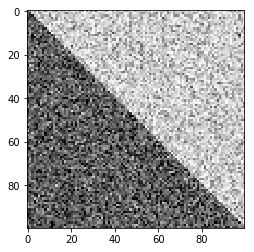

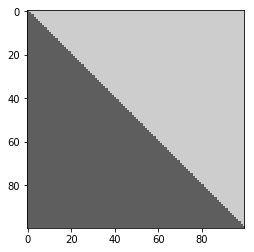

In [17]:
def ref_step_image_BW(n=100):
    ref_img = 0.7 + 0*np.random.normal(loc=0, scale=0.2, size=(n, n))
    ref_img[np.tril_indices_from(ref_img)] -= 0.4
    ref_img = (np.clip(ref_img, a_min=0, a_max=1) * 255)[:, :, None].astype(int)
    return ref_img

def step_image_BW(n=100):
    ref_img = 0.7 + np.random.normal(loc=0, scale=0.15, size=(n, n))
    ref_img[np.tril_indices_from(ref_img)] -= 0.4
    ref_img = (np.clip(ref_img, a_min=0, a_max=1) * 255)[:, :, None].astype(int)
    return ref_img

plt.imshow(step_image_BW(100)[:, :, 0], cmap="Greys_r", vmin=0, vmax=255)
plt.show()
plt.imshow(ref_step_image_BW(100)[:, :, 0], cmap="Greys_r", vmin=0, vmax=255)
plt.show()

In [18]:
np.random.seed(12)
ref_img = step_image_BW(n=200)

lambd0 = 100
sigma_xy0 = 10
sigma_l0 = 50

for lambd in [0.1, 1, 10, 50, 100, 200, 1000]:
    new_img = smoothing(
        ref_img=ref_img,
        lambd=lambd, sigma_xy=sigma_xy0, sigma_l=sigma_l0,
        sigma_s=None, sigma_r=None,
        file_name="diag_lambda_{}_{}_{}".format(lambd, sigma_xy0, sigma_l0), show=False
    )
    
for sigma_xy in [2, 5, 10, 20, 50, 100]:
    new_img = smoothing(
        ref_img=ref_img,
        lambd=lambd0, sigma_xy=sigma_xy, sigma_l=sigma_l0,
        sigma_s=None, sigma_r=None,
        file_name="diag_sigmaxy_{}_{}_{}".format(lambd0, sigma_xy, sigma_l0), show=False
    )
    
for sigma_l in [5, 10, 20, 30, 50, 100, 150, 200, 300]:
    new_img = smoothing(
        ref_img=ref_img,
        lambd=lambd0, sigma_xy=sigma_xy0, sigma_l=sigma_l,
        sigma_s=None, sigma_r=None,
        file_name="diag_sigmal_{}_{}_{}".format(lambd0, sigma_xy0, sigma_l), show=False
    )

Splat matrix computation: 0it [00:00, ?it/s]
Blur matrix computation: 100%|██████████| 6/6 [00:00<00:00, 1649.24it/s]
Bistochastization: 0it [00:00, ?it/s]
Pyramid space construction: 0it [00:00, ?it/s]
Conjugate gradient - channel 0: 100%|██████████| 25/25 [00:00<00:00, 3550.52it/s]
Splat matrix computation: 0it [00:00, ?it/s]
Blur matrix computation: 100%|██████████| 6/6 [00:00<00:00, 1363.71it/s]
Bistochastization: 0it [00:00, ?it/s]
Pyramid space construction: 0it [00:00, ?it/s]
Conjugate gradient - channel 0: 100%|██████████| 25/25 [00:00<00:00, 2983.32it/s]
Splat matrix computation: 0it [00:00, ?it/s]
Blur matrix computation: 100%|██████████| 6/6 [00:00<00:00, 1663.86it/s]
Bistochastization: 0it [00:00, ?it/s]
Pyramid space construction: 0it [00:00, ?it/s]
Conjugate gradient - channel 0: 100%|██████████| 25/25 [00:00<00:00, 2564.63it/s]
Splat matrix computation: 0it [00:00, ?it/s]
Blur matrix computation: 100%|██████████| 6/6 [00:00<00:00, 1133.39it/s]
Bistochastization: 0it [00:

### 2.2 Cartooning and sharpening

Splat matrix computation: 0it [00:00, ?it/s]
Blur matrix computation: 100%|██████████| 10/10 [00:00<00:00, 79.13it/s]
Bistochastization: 0it [00:00, ?it/s]
Pyramid space construction: 0it [00:00, ?it/s]
Conjugate gradient - channel 2: 100%|██████████| 25/25 [00:00<00:00, 146.70it/s]


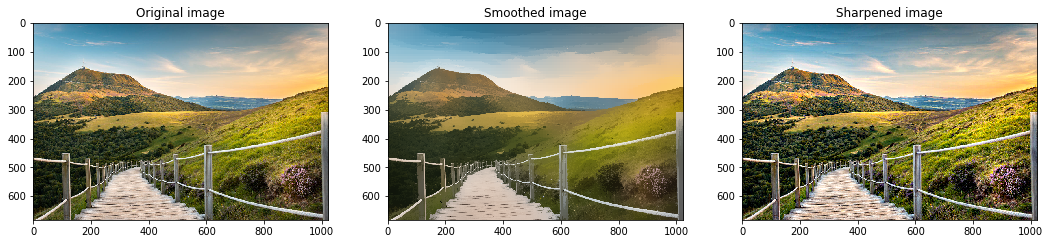

Splat matrix computation: 0it [00:00, ?it/s]
Blur matrix computation: 100%|██████████| 10/10 [00:00<00:00, 97.28it/s]
Bistochastization: 0it [00:00, ?it/s]
Pyramid space construction: 0it [00:00, ?it/s]
Domain transform - iteration 1 - rows: 100%|██████████| 682/682 [00:02<00:00, 228.50it/s]


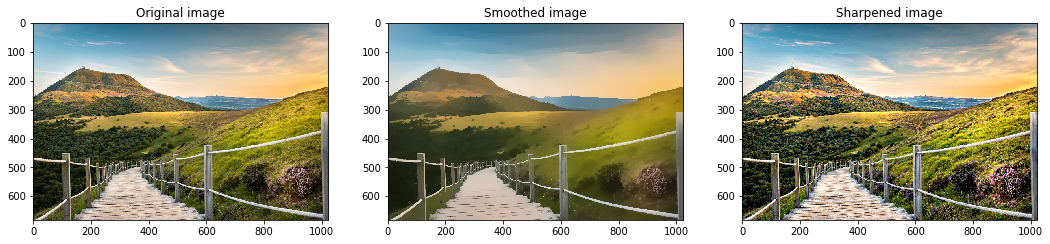

In [19]:
ref_img = (mpimg.imread("pictures/auvergne.jpg")).astype(int)

new_img = smoothing(
    ref_img=ref_img,
    lambd=100, sigma_xy=10, sigma_rgb=50,
    show=True, file_name="auvergne",
    sharp=True
)
# Domain transform post-processing
new_img_DT = smoothing(
    ref_img=ref_img,
    lambd=100, sigma_xy=10, sigma_rgb=50,
    sigma_s=20, sigma_r=50, dt_it=1,
    show=True, file_name="auvergne_DT",
    sharp=True
)

Splat matrix computation: 0it [00:00, ?it/s]
Blur matrix computation: 100%|██████████| 10/10 [00:00<00:00, 201.68it/s]
Bistochastization: 0it [00:00, ?it/s]
Pyramid space construction: 0it [00:00, ?it/s]
Conjugate gradient - channel 2: 100%|██████████| 25/25 [00:00<00:00, 286.71it/s]


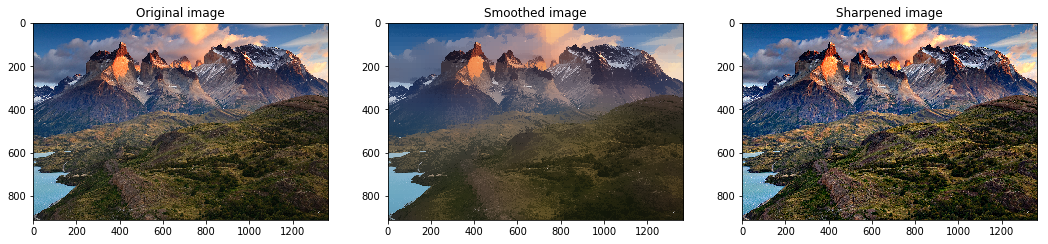

Splat matrix computation: 0it [00:00, ?it/s]
Blur matrix computation: 100%|██████████| 10/10 [00:00<00:00, 210.21it/s]
Bistochastization: 0it [00:00, ?it/s]
Pyramid space construction: 0it [00:00, ?it/s]
Domain transform - iteration 1 - rows: 100%|██████████| 911/911 [00:05<00:00, 167.87it/s]


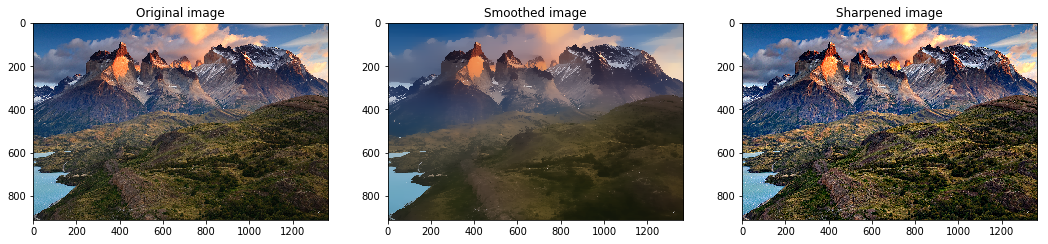

In [20]:
ref_img = (mpimg.imread("pictures/paine.jpg")).astype(int)

new_img = smoothing(
    ref_img=ref_img,
    lambd=50, sigma_xy=20, sigma_rgb=50,
    show=True, file_name="landscape",
    sharp=True
)

new_img = smoothing(
    ref_img=ref_img,
    lambd=50, sigma_xy=20, sigma_rgb=50,
    sigma_s=20, sigma_r=50, dt_it=1,
    show=True, file_name="landscape_DT",
    sharp=True
)

### 2.3 Colorization

Splat matrix computation: 0it [00:00, ?it/s]
Blur matrix computation: 100%|██████████| 6/6 [00:00<00:00, 598.93it/s]
Bistochastization: 0it [00:00, ?it/s]
Pyramid space construction: 0it [00:00, ?it/s]
Domain transform - iteration 3 - rows: 100%|██████████| 583/583 [00:02<00:00, 200.32it/s]


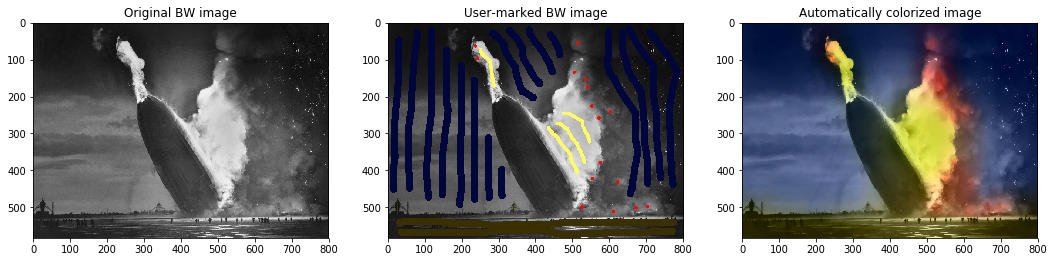

In [21]:
ref_img_BW_pil = Image.open("pictures/hindenburg_BW.jpg").convert("YCbCr")
ref_img_marked_pil = Image.open("pictures/hindenburg_marked.jpg").convert("YCbCr")

ref_img = np.asarray(ref_img_BW_pil)[:, :, :1]
target_img = np.asarray(ref_img_marked_pil)[:, :, :]

new_img = colorization(
    ref_img=ref_img, target_img=target_img,
    lambd=10, sigma_xy=10, sigma_l=50,
    sigma_s=20, sigma_r=50, dt_it=3,
    file_name="hindenburg"
)

Splat matrix computation: 0it [00:00, ?it/s]
Blur matrix computation: 100%|██████████| 6/6 [00:00<00:00, 31.29it/s]
Bistochastization: 0it [00:00, ?it/s]
Pyramid space construction: 0it [00:00, ?it/s]
Conjugate gradient - channel 2: 100%|██████████| 25/25 [00:00<00:00, 64.79it/s]


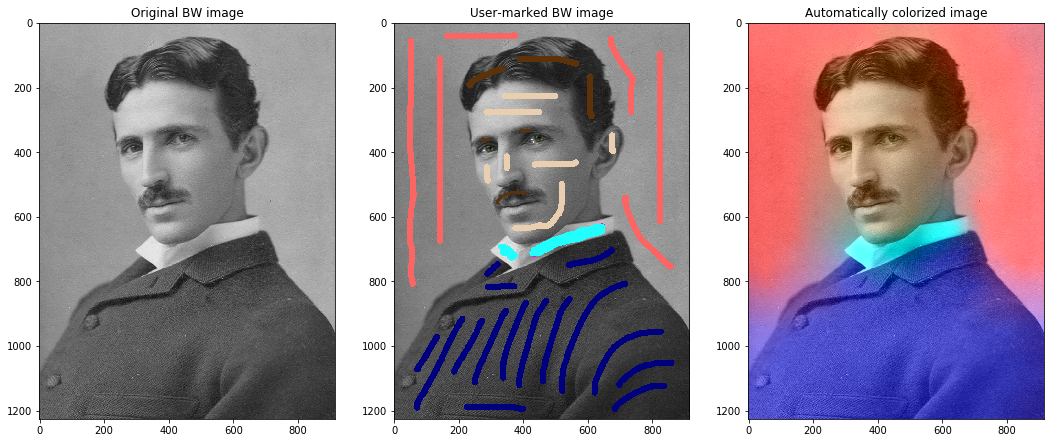

In [22]:
ref_img_BW_pil = Image.open("pictures/tesla_BW.jpg").convert("YCbCr")
ref_img_marked_pil = Image.open("pictures/tesla_marked.jpg").convert("YCbCr")

ref_img = np.asarray(ref_img_BW_pil)[:, :, :1]
target_img = np.asarray(ref_img_marked_pil)[:, :, :]

new_img = colorization(
    ref_img=ref_img, target_img=target_img,
    lambd=100, sigma_xy=5, sigma_l=30,
    file_name="tesla"
)

### 2.4 Depth superresolution

Color photograph and disparity map from the Middlebury dataset

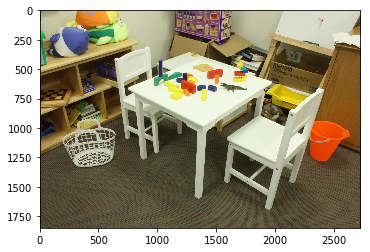

In [23]:
# Color scene
scene_pil = Image.open("pictures/room_color.png")
scene = np.asarray(scene_pil.convert("YCbCr"))
plt.imshow(scene_pil)
plt.show()

# Disparity map
disp = mpimg.imread("pictures/room_disparity.png")

# Depth map computation
doffs=100.279
baseline=193.006
f1=2329.558
depth = baseline * f1 / (disp + doffs)

In [24]:
def ensure_divisibility(scene, disp, depth, f):
    """Crop all images to get a size divisible by f."""
    scene = scene[:f * (scene.shape[0] // f), :f * (scene.shape[1] // f)]
    disp = disp[:f * (disp.shape[0] // f), :f * (disp.shape[1] // f)]
    depth = depth[:f * (depth.shape[0] // f), :f * (depth.shape[1] // f)]
    return scene, disp, depth

def downsample_noise_upsample(depth, disp, noise_level, f):
    """Downsample a depth map, add artificial noise, re-upsample with interpolation."""
    noisy_depth_downsampled = skimage.transform.resize(
    depth + np.random.normal(scale=noise_level * (1 + disp)),
    output_shape=np.array(depth.shape) // f,
    mode="constant", anti_aliasing=False
    )
    noisy_depth_downsampled -= noisy_depth_downsampled.min()

    noisy_depth_reupsampled = skimage.transform.pyramid_expand(
        noisy_depth_downsampled, upscale=f,
        order=3, multichannel=False
    )
    
    return noisy_depth_reupsampled

Artifial noise addition and downsampling of the depth map, followed by interpolated upsampling

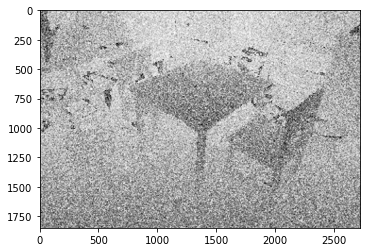

In [25]:
# Std of artificial noise
noise_level = 15
# Downsampling factor
f = 8

scene, disp, depth = ensure_divisibility(scene, disp, depth, f)

noisy_depth = downsample_noise_upsample(depth, disp, noise_level, f)
plt.imshow(noisy_depth, cmap="Greys_r")

Splat matrix computation: 0it [00:00, ?it/s]
Blur matrix computation: 100%|██████████| 10/10 [00:01<00:00,  8.59it/s]
Bistochastization: 0it [00:00, ?it/s]
Pyramid space construction: 0it [00:00, ?it/s]
Conjugate gradient - channel 0: 100%|██████████| 25/25 [00:02<00:00, 10.68it/s]


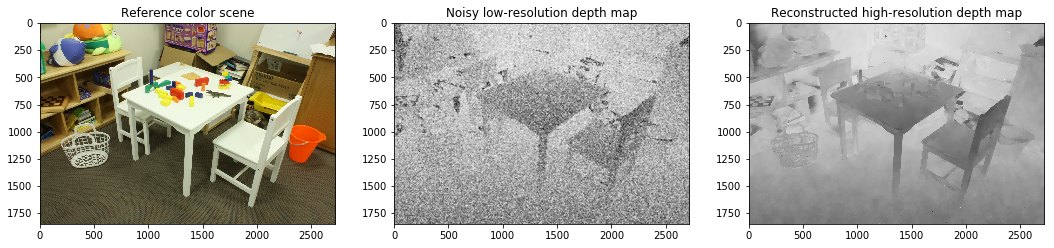

In [26]:
ref_img = scene
target_img = noisy_depth[:, :, None]

new_img = depth_superresolution(
    ref_img, target_img, f,
    lambd=5, sigma_xy=10, sigma_l=5, sigma_uv=30,
    show=True, file_name=None
)

save_depth_superresolution(ref_img, normalize(target_img), normalize(new_img), "room")